In [37]:
%pylab inline
import numpy as np
import scipy.stats as spstats
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/home/elplatt/NetFT/venv/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
out_dirs = [
    "archive/paper-2.0/nk_delete 1/2017-09-05 20:43:37 fc24cdf",
    "archive/paper-2.0/nk_delete 2/2017-09-05 20:43:40 fc24cdf",
    "archive/paper-2.0/nk_delete 3/2017-09-05 20:43:43 fc24cdf",
    "archive/paper-2.0/nk_delete 4/2017-09-05 20:43:37 fc24cdf",
    "archive/paper-2.0/nk_delete 5/2017-09-05 20:43:37 fc24cdf",
    "archive/paper-2.0/nk_delete 6/2017-09-05 20:43:43 fc24cdf"
]

In [51]:
df_runs = pd.concat([pd.DataFrame.from_csv("%s/runs.csv" % d) for d in out_dirs])
df_values = pd.concat([pd.DataFrame.from_csv("%s/values.csv" % d) for d in out_dirs])
df_values["trial_id"] = df_values["timestamp"].map(str) + "-" + df_values["jobid"].map(str) + "-" + df_values["trial"].map(str)
keeps = sorted(set(df_values["keep"]))
strategies = sorted(set(df_values["strategy"]))
trials = sorted(set(df_values["trial_id"]))

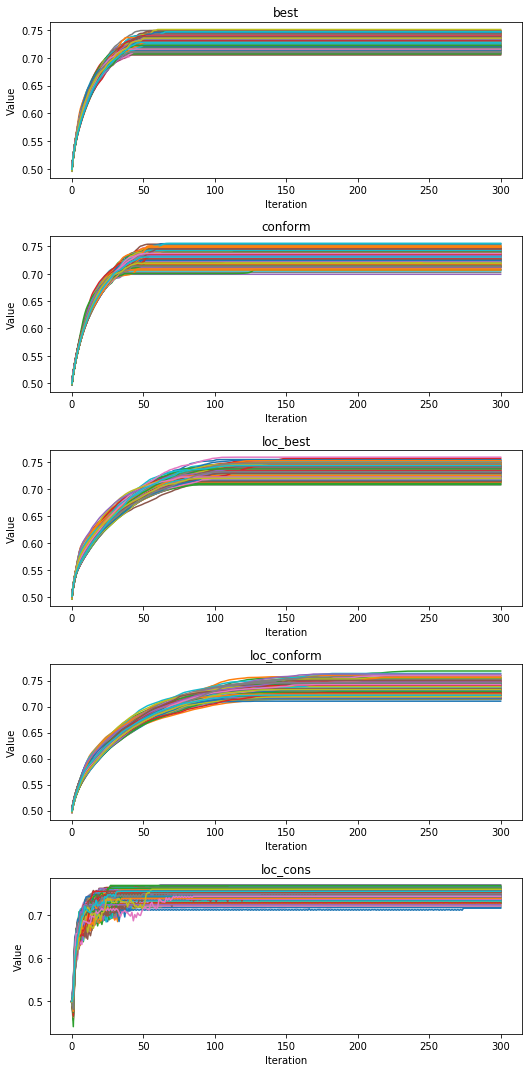

In [52]:
plt.figure(figsize=(3*15.0/6.0,6*15.0/6.0))
for j, strategy in enumerate(strategies):
    df_strategy = df_values[df_values["strategy"] == strategy]
    plt.subplot(len(strategies),1,1+j)
    plt.title(strategy)
    plt.ylabel("Rewire = %0.2f" % r)
    for trial_n in sorted(set(df_strategy["trial_id"])):
        df_trial = df_strategy[df_strategy["trial_id"] == trial_n]
        plot(df_trial["step"], df_trial["value"])
        xlabel("Iteration")
        ylabel("Value")
plt.tight_layout()

In [ ]:
plt.savefig("fig-trials.png", format="png", dpi=300)

In [53]:
def values_to_efficiency(values):
    max_delta = [max(values) - values[i] for i in range(len(values))]
    nonpositive = [i for i, d in enumerate(max_delta) if d <= 0.0001]
    return 1.0 / float(nonpositive[0])

def values_to_converge(values):
    max_delta = [max(values) - values[i] for i in range(len(values))]
    nonpositive = [i for i, d in enumerate(max_delta) if d <= 0.0001]
    return nonpositive[0]    

In [55]:
d_trial = []
d_strat = []
d_eff = []
d_perf = []
d_rewire = []
d_degree = []
d_converge = []
for i, trial in enumerate(sorted(set(df_values["trial_id"]))):
    for j, strategy in enumerate(strategies):
        df_strat = df_values[df_values["strategy"] == strategy]
        df = df_strat[df_strat["trial_id"] == trial]
        eff = values_to_efficiency(list(df["value"]))
        d_converge.append(values_to_converge(list(df["value"])))
        d_trial.append(trial)
        d_strat.append(strategy)
        d_eff.append(eff)
        d_rewire.append(df_runs["rewire"][trial])
        d_degree.append(df_runs["degree"][trial])
        d_perf.append(df_runs["%s_perf" % strategy][trial])
df_eff = pd.DataFrame({
    "trial_id": d_trial,
    "rewire": d_rewire,
    "degree": d_degree,
    "strategy": d_strat,
    "eff": d_eff,
    "perf": d_perf,
    "converge": d_converge
})

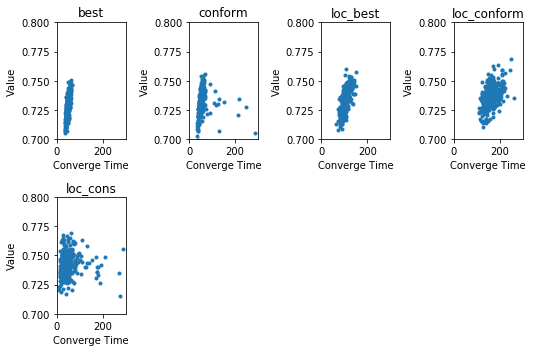

In [56]:
plt.figure(figsize=(3*15.0/6.0,2*15.0/6.0))
for i, strategy in enumerate(strategies):
    plt.subplot(2,4, i+1)
    plt.title(strategy)
    df = df_eff[df_eff["strategy"] == strategy]
    plot(df["converge"], df["perf"], '.')
    xlabel('Converge Time')
    ylabel('Value')
    xlim([0, 300])
    ylim([0.7, 0.8])
plt.tight_layout()

In [ ]:
plt.savefig("fig-converge-value.png", format="png", dpi=300)

In [ ]:
plt.figure(figsize=(4*4,4*2))
for j, strategy in enumerate(strategies):
    df_strategy = df_values[df_values["strategy"] == strategy]
    plt.subplot(2,4,1+j)
    plt.title("Strategy: %s" % strategy)
    for i, k in enumerate(keeps):
        df_k = df_strategy[df_strategy["keep"] == k]
        label = "Keep = %0.2f" % k
        step_mean = []
        step_se = []
        for step in sorted(set(df_k["step"])):
            df = df_k[df_k["step"] == step]
            step_mean.append(df["value"].mean())
            s = df["value"].std(ddof=1)
            step_se.append(s / sqrt(len(df["value"])))
        mean = np.array(step_mean)
        se = np.array(step_se)
        plt.fill_between(range(len(step_mean)), mean - se, mean + se, facecolor="#dfdfff")
        plt.plot(step_mean, label=label)
    plt.legend()
    plt.grid()
    plt.ylim([0.5, 0.8])
    plt.ylim([0.72, 0.76])
plt.tight_layout()

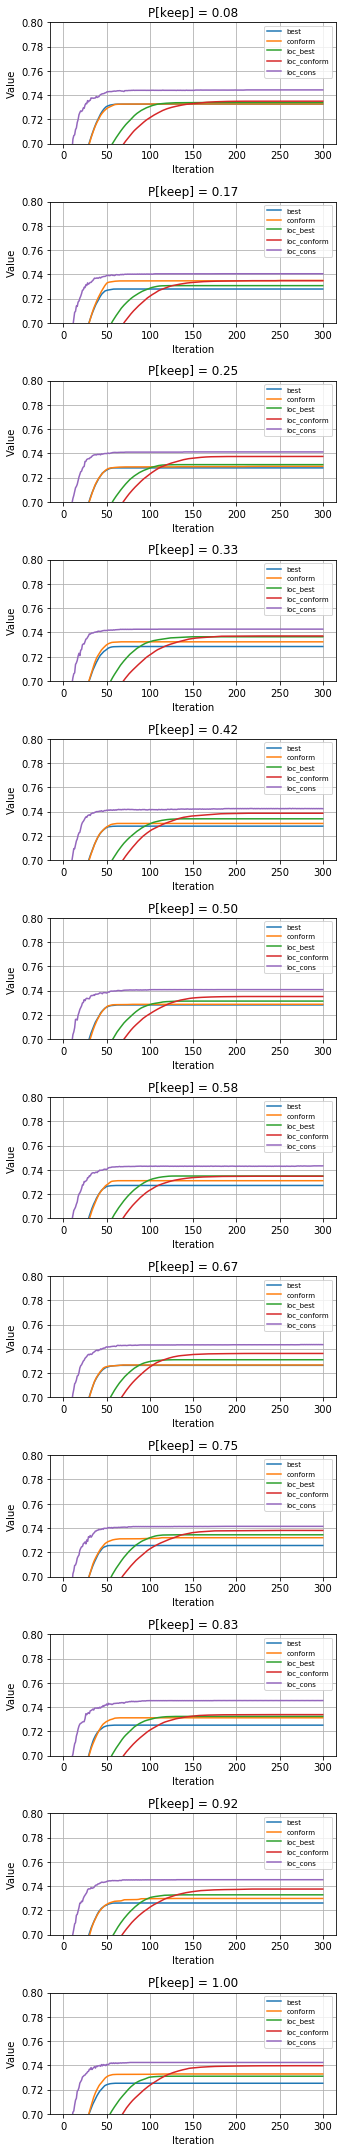

In [68]:
plt.figure(figsize=(2.0*15.0/6.0,len(keeps)*15.0/6.0))
for i, k in enumerate(keeps):
    df_k = df_values[df_values["keep"] == k]
    plt.subplot(len(keeps),1,1+i)
    plt.title("P[keep] = %0.2f" % k)
    for j, strategy in enumerate(strategies):
        df = df_k[df_k["strategy"] == strategy]
        label = strategy
        step_mean = []
        step_se = []
        for step in sorted(set(df["step"])):
            step_df = df[df["step"] == step]
            step_mean.append(step_df["value"].mean())
            s = step_df["value"].std(ddof=1)
            step_se.append(s / sqrt(len(df["value"])))
        mean = np.array(step_mean)
        se = np.array(step_se)
        plt.fill_between(range(len(step_mean)), mean - se, mean + se, facecolor="#dfdfff")
        plt.plot(step_mean, label=label)
        xlabel("Iteration")
        ylabel("Value")
    plt.ylim([0.7, 0.8])
    plt.grid()
    plt.legend(fontsize=7)
plt.tight_layout()

In [ ]:
plt.savefig("fig-val-iter.pdf", format="pdf")
plt.savefig("fig-val-iter.png", format="png", dpi=300)

In [69]:
def estimate_curve(data_x, data_y, points, window):
    h = max(data_x)
    l = min(data_x)
    step = (h-l)/float(points - 1)
    curve_x = np.arange(points) * step + l
    curve_y = np.ones(points)
    for j, x in enumerate(curve_x):
        total = 0.0
        norm = 0.0
        for i, dx in enumerate(data_x):
            dy = data_y[i]
            total += dy * np.exp(-1 * np.power(x - dx, 2) / (2.0*window))
            norm += np.exp(-1 * np.power(x - dx, 2) / (2.0*window))
        curve_y[j] = total / norm
    return curve_x, curve_y

def line_points(m, b, x):
    x0 = min(x)
    x1 = max(x)
    y0 = m*x0 + b
    y1 = m*x1 + b
    return [x0,x1], [y0,y1]

best r=-0.19 p=0.0004 m=-0.000050, b=0.730497
conform r=-0.05 p=0.3099 m=-0.000015, b=0.731932
loc_best r=-0.02 p=0.7094 m=-0.000006, b=0.733161
loc_conform r=0.06 p=0.2472 m=0.000017, b=0.735461
loc_cons r=0.06 p=0.2352 m=0.000018, b=0.741619


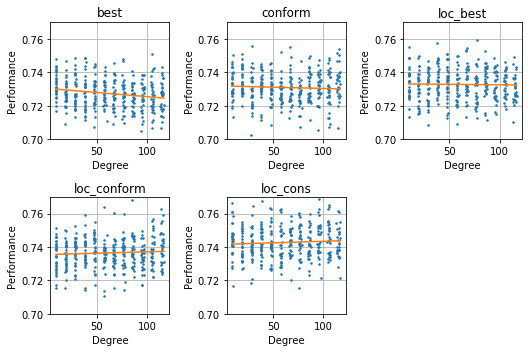

In [71]:
plt.figure(figsize=(3.0*15.0/6.0,2*15.0/6.0))
for j, strategy in enumerate(strategies):
    plt.subplot(2,3,1+j)
    r,p = spstats.pearsonr(df_runs["degree"], df_runs["%s_perf" % strategy])
    plt.plot(df_runs["degree"], df_runs["%s_perf" % strategy], '.', markersize=3)
    m, b = np.polyfit(df_runs["degree"], df_runs["%s_perf" % strategy], 1)
    #x, y = estimate_curve(df_runs["degree"], df_runs["%s_perf" % strategy], 100, 5)
    x, y = line_points(m,b,df_runs["degree"])
    plt.plot(x, y, '-')
    plt.title(strategy)
    print "%s r=%0.2f p=%0.4f m=%f, b=%f" % (strategy, r, p, m, b)
    xlabel("Degree")
    ylabel("Performance")
    plt.grid()
    plt.ylim([0.7, 0.77])
plt.tight_layout()

In [ ]:
plt.savefig("fig-deg-perf.pdf", format="pdf")
plt.savefig("fig-deg-perf.png", format="png", dpi=300)

best r=0.17 p=0.0011 m=0.000014, b=0.020503
conform r=0.02 p=0.7488 m=0.000002, b=0.019585
loc_best r=0.08 p=0.1324 m=0.000003, b=0.009645
loc_conform r=-0.03 p=0.6243 m=-0.000001, b=0.006515
loc_cons r=-0.03 p=0.5264 m=-0.000016, b=0.030597


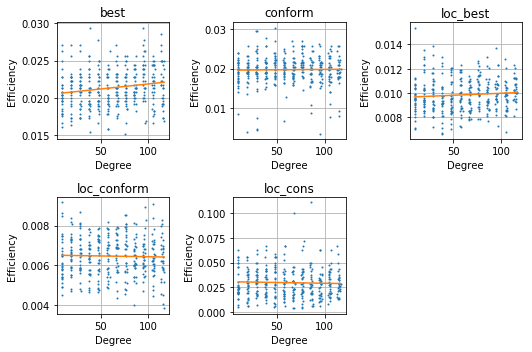

In [73]:
plt.figure(figsize=(3.0*15.0/6.0,2*15.0/6.0))
for j, strategy in enumerate(strategies):
    plt.subplot(2,3,1+j)
    df = df_eff[df_eff["strategy"] == strategy]
    r,p = spstats.pearsonr(df["degree"], df["eff"])
    m, b = np.polyfit(df["degree"], df["eff"], 1)
    #x, y = estimate_curve(df_strat["degree"], df_strat["eff"], 100, 5)
    x, y = line_points(m,b,df["degree"])
    plt.plot(df["degree"], df["eff"], '.', markersize=2)
    plt.plot(x, y)
    plt.title(strategy)
    print "%s r=%0.2f p=%0.4f m=%f, b=%f" % (strategy, r, p, m, b)
    xlabel("Degree")
    ylabel("Efficiency")
    plt.grid()
plt.tight_layout()

In [ ]:
plt.savefig("fig-deg-eff.pdf", format="pdf")
plt.savefig("fig-deg-eff.png", format="png", dpi=300)